## Analyse predictions of retrained models

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from tqdm.auto import tqdm

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score, f1_score, precision_score, recall_score, average_precision_score, balanced_accuracy_score

from rdkit import Chem
from rdkit.Chem import SaltRemover
from rdkit.Chem import AllChem, DataStructs
from rdkit import RDLogger

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Disable rdkit logger
RDLogger.DisableLog('rdApp.*') 

In [3]:
%%bash
ls ../../data/test/

aggregators.npy
chembl.npy
fluc.csv
nluc.csv
redox.csv
thiol.csv


In [4]:
### DEFINE THE TASK
tasks = ["fluc", "nluc", "thiol", "redox"]

In [5]:
# Compute the fingerprints
def compute_morgan(smile, radius):
    molecule = Chem.MolFromSmiles(smile)
    fp_object = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=2048)
    morgan_fp = np.zeros((0, ))
    DataStructs.ConvertToNumpyArray(fp_object, morgan_fp)

    return morgan_fp

In [6]:
def preprocess(smiles):
    salt_remover = SaltRemover.SaltRemover()
    smiles = smiles.replace("@", "")
    smiles = smiles.replace("/", "")
    mol = Chem.MolFromSmiles(smiles)
    mol = salt_remover.StripMol(mol)

    return Chem.MolToSmiles(mol)

### Compute performances of the original trained model

In [7]:
# Compute train set fingerprints
train_dict = {i: None for i in tasks}
for task in tasks:
    train_data = pd.read_csv(f"../../data/train/{task}.csv")
    train_data["smiles"] = train_data["smiles"].apply(preprocess)

    train_smiles = train_data["smiles"].values
    train_labels = train_data["label"].values
    train_fps = [compute_morgan(smi, 3) for smi in tqdm(train_smiles)]
    train_dict[task] = (train_fps, train_labels)

  0%|          | 0/3924 [00:00<?, ?it/s]

  0%|          | 0/3918 [00:00<?, ?it/s]

  0%|          | 0/3846 [00:00<?, ?it/s]

  0%|          | 0/3894 [00:00<?, ?it/s]

In [8]:
# Compute test set fingerprints
test_dict = {i: None for i in tasks}
for task in tasks:
    test_data = pd.read_csv(f"../../data/test/{task}.csv")
    test_data["smiles"] = test_data["smiles"].apply(preprocess)

    test_smiles = test_data["smiles"].values
    test_labels = test_data["label"].values
    test_fps = [compute_morgan(smi, 3) for smi in tqdm(test_smiles)]
    test_dict[task] = (test_fps, test_labels)

  0%|          | 0/981 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/962 [00:00<?, ?it/s]

  0%|          | 0/974 [00:00<?, ?it/s]

In [9]:
for task, labels in test_dict.items():
    print(f"\n{task}")
    print("Test set positives:" , (np.sum(labels[1])))
    print("Percentage of positives in test set:", (np.sum(labels[1])) / len(labels[1]) * 100)


fluc
Test set positives: 28
Percentage of positives in test set: 2.854230377166157

nluc
Test set positives: 15
Percentage of positives in test set: 1.530612244897959

thiol
Test set positives: 198
Percentage of positives in test set: 20.582120582120584

redox
Test set positives: 29
Percentage of positives in test set: 2.97741273100616


In [10]:
for train, test in zip(train_dict.values(), test_dict.values()):
    print(f"\n{task}")
    print("len(train):", len(train[0]))
    print("len(test):", len(test[0]))
    print(len(test[0])/len(train[0]))


redox
len(train): 3924
len(test): 981
0.25

redox
len(train): 3918
len(test): 980
0.2501276161306789

redox
len(train): 3846
len(test): 962
0.250130005200208

redox
len(train): 3894
len(test): 974
0.2501284026707756


In [11]:
def predict_with_random_seed(task):
    # Load optimized hyperparameters
    hyperparameters = np.load(f"../../FtF4/teacher/results/validation/{task}.npy", allow_pickle=True)[()]

    # Instantiate the model
    model = BalancedRandomForestClassifier(
                n_estimators = hyperparameters["n_estimators"],
                max_depth = hyperparameters["max_depth"],
                min_samples_split = hyperparameters["min_samples_split"],
                max_features = hyperparameters["max_features"],
                bootstrap = True,
                n_jobs = 32,
                random_state = np.random.randint(0, 1000),
                )

    # Train and validate.
    model.fit(train_fps, train_labels)

    # Compute predictions on the test set
    preds = model.predict_proba(test_fps)[:, 1]
    preds_binary = (preds >= 0.5).astype(int)

    return preds, preds_binary

# Compute the enrichment factor
def ef(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred)
    prevalence = np.sum(y_true) / len(y_true)
    
    return precision / prevalence
# def ef(y_true, y_pred):
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)

#     precision = precision_score(y_true, y_pred)
#     prevalence = np.sum(y_true) / len(y_true)
    
#     return precision / prevalence

def compute_performance_teacher(task, iter):

    performances = {i: None for i in range(1, iter+1)}
    
    for i in range(iter):
        preds, preds_binary = predict_with_random_seed(task)
            
        tmp_performances = {
                        "positive": np.sum(preds_binary),
                        "mcc": matthews_corrcoef(test_labels, preds_binary),
                        "roc_auc": roc_auc_score(test_labels, preds),
                        "f1": f1_score(test_labels, preds_binary),
                        "precision": precision_score(test_labels, preds_binary),
                        "recall": recall_score(test_labels, preds_binary),
                        "bacc": balanced_accuracy_score(test_labels, preds_binary),
                        "ef" : ef(test_labels, preds_binary)
                        }
        tmp_performances["pr_auc"] = average_precision_score(test_labels, preds)
        
        performances[i+1] = tmp_performances

    df = pd.DataFrame.from_dict(performances)

    return df.T


In [12]:
teacher_dict = {i: None for i in tasks}
for task in tqdm(tasks):
    train_fps, train_labels = train_dict[task]
    test_fps, test_labels = test_dict[task]
    teacher_performances = compute_performance_teacher(task, 5)
    teacher_dict[task] = teacher_performances

  0%|          | 0/4 [00:00<?, ?it/s]

/data/shared/software/conda/vincenzo_palmacci/miniconda3/envs/reinvent4/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/data/shared/software/conda/vincenzo_palmacci/miniconda3/envs/reinvent4/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/data/shared/software/conda/vincenzo_palmacci/miniconda3/envs/reinvent4/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` i

In [13]:
from IPython.display import HTML

def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [14]:
side_by_side(teacher_dict["fluc"].describe(), teacher_dict["nluc"].describe(), teacher_dict["thiol"].describe(), teacher_dict["redox"].describe())

,positive,mcc,roc_auc,f1,precision,recall,bacc,ef,pr_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,339.200000,0.220563,0.887843,0.146236,0.079179,0.957143,0.814668,2.774084,0.212816
std,18.130085,0.010464,0.010434,0.007234,0.004204,0.015972,0.011943,0.147283,0.021740
min,321.000000,0.208110,0.877530,0.136020,0.073171,0.928571,0.801641,2.563589,0.192467
25%,330.000000,0.211688,0.880827,0.142857,0.077381,0.964286,0.802709,2.711097,0.198294
50%,336.000000,0.222490,0.883807,0.146739,0.079412,0.964286,0.817925,2.782248,0.207326
75%,340.000000,0.227793,0.894319,0.150838,0.081818,0.964286,0.823171,2.866558,0.218489
max,369.000000,0.232736,0.902732,0.154728,0.084112,0.964286,0.827893,2.946929,0.247502
,positive,mcc,roc_auc,f1,precision,recall,bacc,ef,pr_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


### Load retrained models and recompute the test set performance

In [15]:
def compute_retrained_performances(task, sampling, iter, version):
    # Load the trained model
    performances = {i: None for i in range(1, iter+1)}
    for i in range(iter):
        model_path = f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/{task}_{i+1}.pkl"

        #if f"{task}_{i+1}.pkl" in os.listdir(f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/"):
        with open(model_path, "rb") as f:
            model = pickle.load(f)

        # Predict the test set
        test_preds = model.predict_proba(test_dict[task][0])
        test_labels = test_dict[task][1]

        test_preds = test_preds[:, 1]
        test_preds_binary = (test_preds > 0.5).astype(int)
            
        tmp_performances = {
                        "positive": np.sum(test_preds_binary),
                        "mcc": matthews_corrcoef(test_labels, test_preds_binary),
                        "roc_auc": roc_auc_score(test_labels, test_preds),
                        "f1": f1_score(test_labels, test_preds_binary),
                        "precision": precision_score(test_labels, test_preds_binary),
                        "recall": recall_score(test_labels, test_preds_binary),
                        "bacc": balanced_accuracy_score(test_labels, test_preds_binary),
                        "ef": ef(test_labels, test_preds_binary)
                        }

        tmp_performances["pr_auc"] = average_precision_score(test_labels, test_preds)
        
        performances[i+1] = tmp_performances

    df = pd.DataFrame.from_dict(performances)

    return df

In [16]:
map_keys = {"fluc": "FI", "nluc": "NI", "redox": "RR", "thiol": "TR"}
map_acq = {"random":"Random", "greedy": "Greedy",  "epig": "EPIG", "greedyskill": "GreedySkill", "epigskill":"EPIGSkill"}

In [17]:
def compute_performace_df(task, version, metric):
    # Compute performances for each iteration
    mcc = {map_acq[i]: None for i in ["random", "greedy",  "epig", "greedyskill", "epigskill"]}
    for i in ["random", "greedy",  "epig", "greedyskill", "epigskill"]:
        df = compute_retrained_performances(task, i, 10, version).T
        df = df.reset_index()

        mcc[map_acq[i]] = df[metric].values

    df = pd.DataFrame(mcc)

    return df

In [18]:
metric = "ef"

In [19]:
performances_dict = {i: None for i in tasks}
for task in tasks:
    print(f"\n{task}")
    mcc_across_versions = {i: None for i in range(1, 6)}
    for i in tqdm(range(1, 6)):
        try:
            df = compute_performace_df(task, i, metric)
        except:
            print(f"Version {i} failed")
        df["Iteration"] = [str(j +1) for j in df.index]
        mcc_across_versions[i] = df.dropna(axis=0)

    # Combine the DataFrames
    df_combined = pd.concat([i for i in mcc_across_versions.values()])
    df_melted = pd.melt(df_combined, id_vars="Iteration", var_name="Acquisition\nfunction", value_name="MCC")

    performances_dict[task] = df_melted


fluc


  0%|          | 0/5 [00:00<?, ?it/s]


nluc


  0%|          | 0/5 [00:00<?, ?it/s]


thiol


  0%|          | 0/5 [00:00<?, ?it/s]


redox


  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
palette = ["#808080", "#ee82ee", "#FFA500", "#7741f7", "#805380"]

In [21]:
map_keys = {"fluc": "FI", "nluc": "NI", "redox": "RR", "thiol": "TR"}

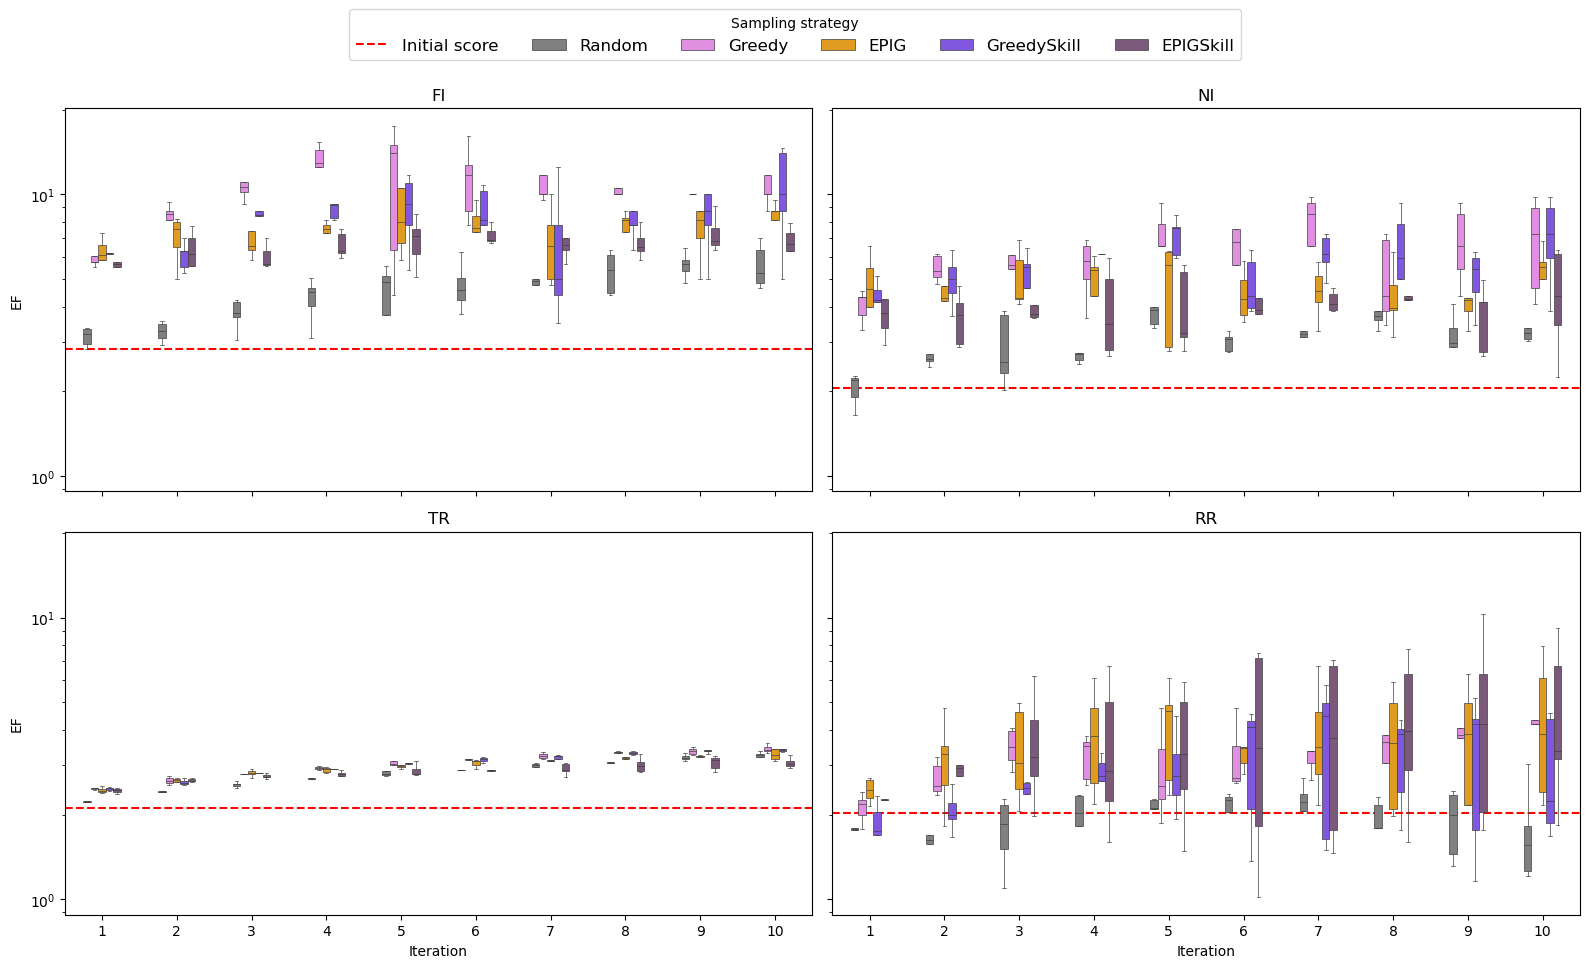

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharey=True, sharex=True)
for i, (task, df) in enumerate(performances_dict.items()):
    x = int(i/2)
    y = i % 2
    axes[x][y].axhline(y=teacher_dict[task][metric].mean(), color='r', linestyle='--', label="Initial score")
    # boxplot with log scale
    sns.boxplot(x="Iteration", y=f"MCC", hue="Acquisition\nfunction", data=df, palette=palette, dodge=True, orient="v", width=0.5, linewidth=0.5, ax=axes[x][y], legend=True, showfliers=False)
    axes[x][y].set_yscale("log")
    # Plot horizontal line at teacher mean
    axes[x][y].set_title(f"{map_keys[task]}")
    axes[x][y].set_ylabel(metric.upper())
    axes[x][y].legend_.remove()
# Create shared legend
handles, labels = axes[0][0].get_legend_handles_labels()
legend = fig.legend(
    handles, 
    labels, 
    title="Sampling strategy", 
    bbox_to_anchor=(0.5, 1.08), 
    loc='upper center', 
    ncol=6, 
    fontsize=12,
)

for text in legend.get_texts():
    text.set_bbox(dict(facecolor='none', edgecolor='none'))  # Remove rectangle around label text

plt.tight_layout()
plt.show()

/tmp/ipykernel_3815/494959933.py:4: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x="Iteration", y="MCC", hue="Acquisition\nfunction", data=df_melted, palette=palette, dodge=True, orient="v", width=0.5)


Text(0, 0.5, 'MCC')

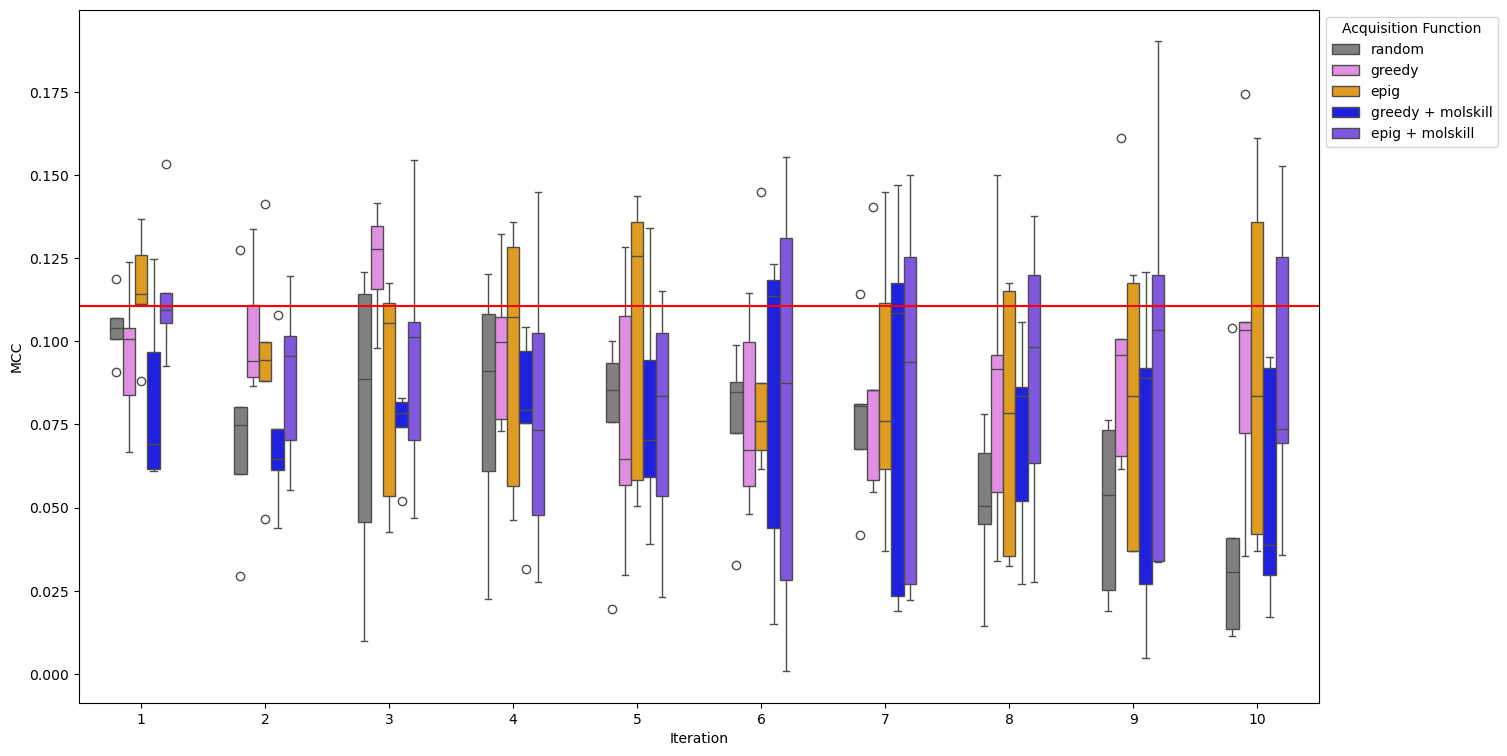

In [ ]:
plt.figure(figsize=(16, 9))
# sns.barplot(x="Iteration", y="MCC", hue="Acquisition\nfunction", data=df_melted, palette=palette,
#              errorbar="se", err_kws={'linewidth': 1.0}, capsize=0.2, linewidth=1.0,  edgecolor="k")
sns.boxplot(x="Iteration", y="MCC", hue="Acquisition\nfunction", data=df_melted, palette=palette, dodge=True, orient="v", width=0.5)
# add horizontal line for the original model
plt.axhline(y=teacher_mcc_mean, color='r', linestyle='--');
# plt.axhline(y=teacher_mcc_mean + teacher_mcc_std, color='r', linestyle='--');

plt.legend(title='Acquisition Function', bbox_to_anchor=(1., 1), loc='upper left')
plt.ylabel(f"{metric.upper()}")
# set y-axis limits
#plt.ylim(0, 0.5)

In [80]:
# plt.figure(figsize=(16, 9))
# # # Plot using seaborn
# sns.violinplot(x="Iteration", y="MCC", hue="Acquisition\nfunction", data=df_melted, palette=palette, linewidth=1.0, edgecolor="k")


# # add ylim
# plt.ylim(0, 1)

# # Add labels and title
# plt.xlabel('Iteration', fontsize=15)
# plt.ylabel(f'{metric.upper()}', fontsize=15)
# plt.title('\nBoxplot of Values Across Categories and Iterations\n', fontsize=15)

# # add horizontal line for the original model
# plt.axhline(y=teacher_mcc_mean, color='r', linestyle='-');
# plt.axhline(y=teacher_mcc_mean + teacher_mcc_std, color='r', linestyle='--');

# # Show the plot
# plt.show()

#### Compute MCC using averaged predictions across versions

In [81]:
def compute_retrained_predictions(task, sampling, iter, version):
    # Load the trained model
    predictions = {i: None for i in range(1, iter+1)}
    for i in range(iter):
        model_path = f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/{task}_{i+1}.pkl"

        if f"{task}_{i+1}.pkl" in os.listdir(f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/"):
            with open(model_path, "rb") as f:
                model = pickle.load(f)

            # Predict the test set
            test_preds = model.predict_proba(test_fps)[:,1]

            predictions[i+1] = test_preds

    return predictions

In [82]:
# Compute the predictions and average across repeats
def compute_ensembled_performances(sampling, metric):
    predictions_dict = {}
    for i in range(1, 6):
        predictions = compute_retrained_predictions(task, sampling, 10, i)
        predictions_dict[i] = predictions_dict.get(i, predictions)

    # Compute the average predictions across versions
    performances = {i: None for i in range(1, 11)}
    for i in performances.keys():
        # compute average predictions for the current iteration i for all the versions j
        arr = []
        for j in predictions_dict.keys():
            p = np.array(predictions_dict[j][i])
            if len(p.shape) == 1:
                arr.append(p)
        # average across columns
        test_preds = np.max(arr, axis=0)
        test_preds_binary = (test_preds >= 0.5).astype(int)
        # compute the performances
        tmp_performances = {
                    "positive": np.sum(test_preds_binary),
                    "mcc": matthews_corrcoef(test_labels, test_preds_binary),
                    "roc_auc": roc_auc_score(test_labels, test_preds),
                    "f1": f1_score(test_labels, test_preds_binary),
                    "precision": precision_score(test_labels, test_preds_binary),
                    "recall": recall_score(test_labels, test_preds_binary),
                    "bacc": balanced_accuracy_score(test_labels, test_preds_binary),
                    }

        tmp_performances["pr_auc"] = average_precision_score(test_labels, test_preds)
                
        performances[i] = tmp_performances[metric]

    return pd.DataFrame.from_dict(performances, orient="index", columns=[metric])

In [83]:
sampling_methods = ["random", "greedy",  "epig", "molskill", "greedy + molskill", "epig + molskill", ]
mcc_across_versions = {i: None for i in sampling_methods}
for idx, i in enumerate(mcc_across_versions.keys()):
    if i == "greedy + molskill":
        j = "greedyskill"
    elif i == "epig + molskill":
        j = "epigskill"
    else:
        j = i
    try:
        df = compute_ensembled_performances(j, metric)
    except:
        df = mcc_across_versions[sampling_methods[idx-1]]
    df["Iteration"] = [str(k) for k in df.index]
    mcc_across_versions[i] = df

In [84]:
performances = pd.concat([i.drop("Iteration", axis=1) for i in mcc_across_versions.values()], axis=1)
performances.columns = sampling_methods

In [85]:
performances

,random,greedy,epig,molskill,greedy + molskill,epig + molskill
1,0.156997,0.202020,0.216216,0.164794,0.266667,0.212389
2,0.152091,0.253521,0.219512,0.155963,0.200000,0.220183
3,0.151111,0.237288,0.210526,0.169312,0.222222,0.224299
4,0.167539,0.264151,0.215385,0.173410,0.253968,0.235294
5,0.169492,0.255319,0.190476,0.169697,0.264151,0.250000
6,0.191083,0.272727,0.196721,0.184211,0.235294,0.263736
7,0.194444,0.243902,0.190476,0.187919,0.200000,0.272727
8,0.184615,0.205128,0.233333,0.171429,0.244898,0.268293
9,0.176000,0.205128,0.178571,0.185714,0.217391,0.275000
10,0.222222,0.205128,0.210526,0.165414,0.232558,0.256410


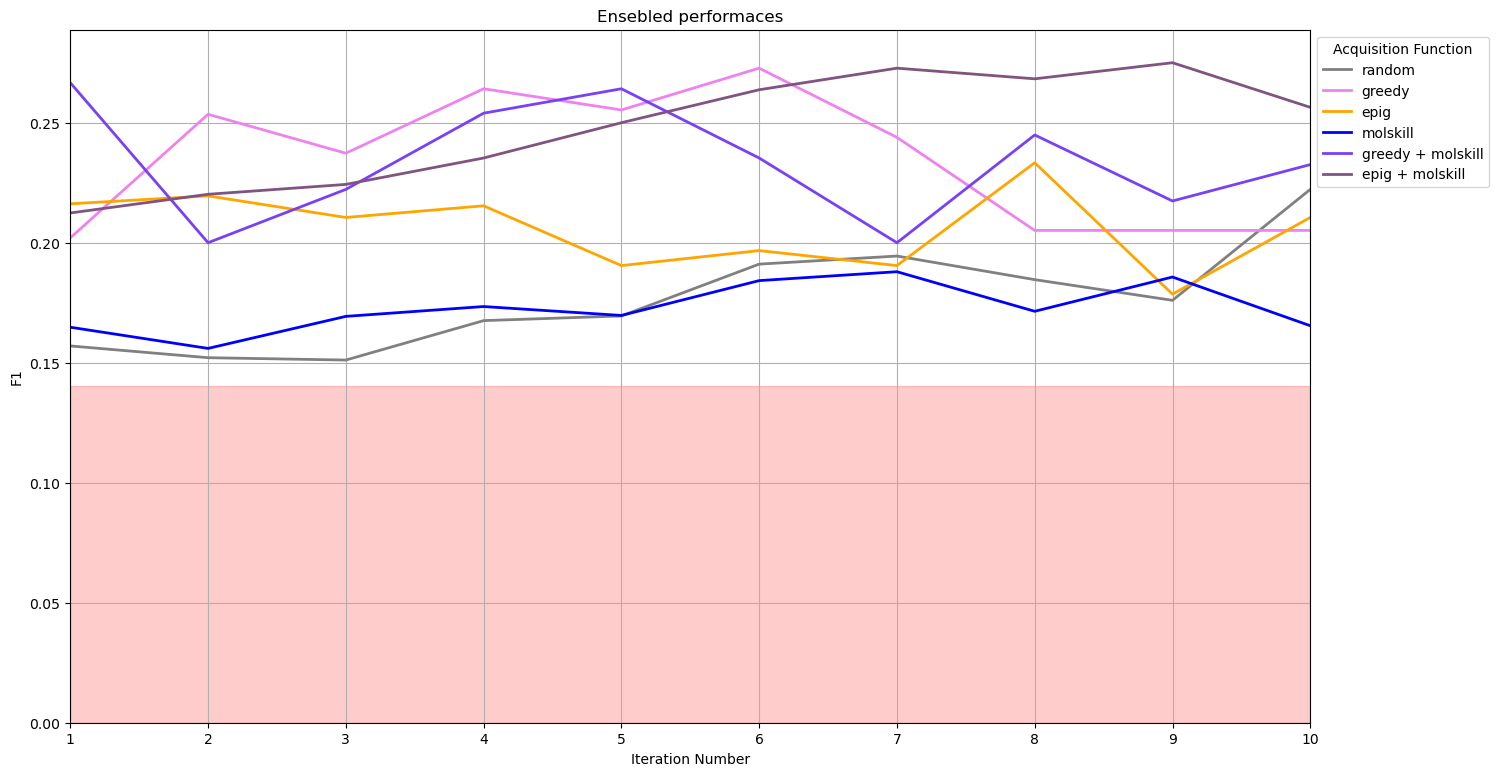

In [86]:
# Use a color map for the different columns
colors = palette

# Create a parallel coordinates plot
plt.figure(figsize=(16, 9))

for idx, column in enumerate(performances.columns):
    plt.plot(performances.index, performances[column], color=colors[idx], label=column, linewidth=2.0)

#plt.axhline(y=teacher_mcc_mean, color='r', linestyle='--');
plt.fill_between(performances.index, 0, teacher_mcc_mean, color='r', alpha=0.2)

plt.xticks(performances.index)  # Set x-ticks to match iteration numbers
plt.xlim(1, 10)  # Set x-axis limits
plt.ylim(0, )  # Set y-axis limits
plt.title('Ensebled performaces')
plt.xlabel('Iteration Number')
plt.ylabel(f"{metric.upper()}")
plt.legend(title='Acquisition Function', bbox_to_anchor=(1., 1), loc='upper left')
plt.grid(True)
plt.show()

#### MOVE models around

In [87]:
def load_teacher(task):
    # Load trained model
    with open(f"../../FtF4/teacher/trained_models/{task}.pkl", "rb") as f:
        model = pickle.load(f)  

    return model

In [88]:
for i in ["fluc", "nluc", "redox", "thiol"]:
    model = load_teacher(i)
    os.makedirs(f"trained_replicates/{i}", exist_ok=True)
    with open(f"trained_replicates/{i}/{i}.pkl", "wb") as f:
        pickle.dump(model, f)

In [89]:
samplings = ["random", "greedy", "epig", "molskill", "epigskill", "greedyskill"]
for j in ["thiol", "fluc", "nluc", "redox"]:
    for i in samplings:
        os.makedirs(f"trained_replicates/{j}/{i}", exist_ok=True)

In [90]:
def move_models(task, sampling, iter, version):
    # Load the trained model
    for i in range(iter):
        model_path = f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/{task}_{i+1}.pkl"

        if f"{task}_{i+1}.pkl" in os.listdir(f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/"):
            with open(model_path, "rb") as f:
                model = pickle.load(f)
        #print(f"Moving {task}_{i+1}.pkl to trained_replicates/{task}/{sampling}/rep{version}/{task}_{i+1}.pkl")
        # copy the model to the new location
        with open(f"trained_replicates/{task}/{sampling}/rep{version}/{task}_{i+1}.pkl", "wb") as f:
            pickle.dump(model, f)
    return model

In [91]:
for task in os.listdir("trained_replicates"): # iterate over the tasks
    for sampling in os.listdir(f"trained_replicates/{task}"): # iterate over the samplings
        for repeat in range(1, 6): # iterate over the versions
            if "." not in sampling: # Use only the sampling directories
                # do what you need to do
                # keeping in mind that you have 5 iterations
                os.makedirs(f"trained_replicates/{task}/{sampling}/rep{repeat}", exist_ok=True)
                print(f"Moving models for {task}, {sampling}, rep{repeat}") # iterate over the iterations
                move_models(task, sampling, 10, repeat)


Moving models for fluc, random, rep1
Moving models for fluc, random, rep2
Moving models for fluc, random, rep3
Moving models for fluc, random, rep4
Moving models for fluc, random, rep5
Moving models for fluc, greedy, rep1
Moving models for fluc, greedy, rep2
Moving models for fluc, greedy, rep3
Moving models for fluc, greedy, rep4
Moving models for fluc, greedy, rep5
Moving models for fluc, epig, rep1
Moving models for fluc, epig, rep2
Moving models for fluc, epig, rep3
Moving models for fluc, epig, rep4
Moving models for fluc, epig, rep5
Moving models for fluc, molskill, rep1
Moving models for fluc, molskill, rep2
Moving models for fluc, molskill, rep3
Moving models for fluc, molskill, rep4
Moving models for fluc, molskill, rep5
Moving models for fluc, epigskill, rep1
Moving models for fluc, epigskill, rep2
Moving models for fluc, epigskill, rep3
Moving models for fluc, epigskill, rep4
Moving models for fluc, epigskill, rep5
Moving models for fluc, greedyskill, rep1
Moving models for 

#### MOVE datasets around

In [92]:
# import os

In [93]:
# for i in tqdm(["fluc", "nluc", "redox", "thiol"]):
#     os.makedirs(f"trained_dataset/{i}", exist_ok=True)
#     source = f"../../data/train/{i}.csv"
#     dest = f"trained_dataset/{i}/{i}.csv"
#     os.system(f'cp {source} {dest}') 

In [94]:
# samplings = ["random", "greedy", "epig", "molskill", "epigskill", "greedyskill"]
# for j in ["thiol", "fluc", "nluc", "redox"]:
#     for i in samplings:
#         os.makedirs(f"trained_dataset/{j}/{i}", exist_ok=True)

In [95]:
# def move_models(task, sampling, iter, version):
#     # Load the trained model
#     for i in range(iter):
#         source = f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/selected_{i+1}.csv"

#         if f"selected_{i+1}.csv" in os.listdir(f"../../FtF4/RUN_REINVENT/v{version}/{sampling}/{task}/"):
#         #print(f"Moving {task}_{i+1}.pkl to trained_replicates/{task}/{sampling}/rep{version}/{task}_{i+1}.pkl")
#         # copy the model to the new location
#             os.system(f'cp {source} trained_dataset/{task}/{sampling}/rep{version}/selected_{i+1}.csv')
#     return print(f"Moved {task}, {sampling}, rep{version}")

In [96]:
# for task in os.listdir("trained_dataset"): # iterate over the tasks - First level of the directory tree
#     for sampling in os.listdir(f"trained_dataset/{task}"): # iterate over the samplings - Second level of the directory tree
#         for repeat in range(1, 6): # iterate over the versions - Third level of the directory tree
#             if "." not in sampling: # Use only the sampling directories
#                 # do what you need to do
#                 # keeping in mind that you have 5 iterations
